In [99]:
import datetime
import tensorflow as tf
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import datetime
import sys
import time
import matplotlib.pyplot as plt
import io
import gzip
from PIL import Image
import time
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from tensorflow.keras import layers
from sklearn.utils import shuffle
def baseCNN(input_shape, classes):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, 3, 1, input_shape=input_shape,padding= 'same',activation= 'relu',kernel_initializer='uniform'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),padding = 'same'))
    model.add(layers.Conv2D(64, 3, 1,padding= 'same',activation= 'relu',kernel_initializer='uniform'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),padding = 'same'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation= 'relu'))
    model.add(layers.Dense(16, activation= 'relu'))
    model.add(layers.Dense(classes, activation= 'softmax'))
    
    return comp(model)
class DataSet(object):
    def __init__(self,batch = 64,dsize = 200,loadfile = None,model = None,n_classes= None, path = None):
        self.X = None
        self.Y = None
        self.train_dataset = None
        self.test_dataset = None
        self.x_val = None
        self.y_val = None
        self.dsize = dsize
        self.n_classes = n_classes
        if path == None:
            self.path = 'data'
        else:
            self.path = path
        start = time.time()
        if loadfile != None:
            print('loading')
            self.ld_data(loadfile)
        else:
            start = time.time()
            self.data(batch, dsize)
        self.model = None
        end = time.time()
        print(f'takes {end-start} seconds to load dataset')
    def train(self,epoch = 10):
        CNN = self.model
        log_dir="logs/fit/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
        tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        early_stop=tf.keras.callbacks.EarlyStopping(monitor= 'val_loss', min_delta=0.002, patience=10, mode='auto')
        callbacks = [tensorboard_callback, early_stop]
        return CNN.fit(self.train_dataset, epochs=epoch,verbose=1, validation_data = (self.x_val,self.y_val), callbacks=callbacks)
    def test(self):
        return self.model.evaluate(self.test_dataset)
    def predict(self, X):
        predictions = self.model.predict(X)
        pred = np.argmax(predictions, axis=1)
        return pred
    def display(self,index):
        img = self.X[index]
        plt.imshow(img)
        img = np.expand_dims(img,0)
        pred= np.argmax(self.model.predict(img), axis=1)
        print(pred[0])
    def plot(self,index):
        img = self.X[index]
        plt.imshow(img)
    def plot_axes(self,n):
        fig,axes = plt.subplots(2,n,figsize = (20,5))
        for i in range(n):
            axes[0,i].imshow(self.X[i])
            axes[0,i].axis('off')
            img = cv2.resize(self.X[i],(28,28))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            axes[1,i].imshow(img)
            axes[1,i].axis('off')
    def save_model(self, name = 'model'):
        path = 'Model/'+name+'.h5'
        self.model.save(path)
        print(f'the model has been saved in {path}')
    def load_model(self, name = 'model'):
        path = 'Model/'+name+'.h5'
        print(f'the model has been loaded from {path}')
        self.model = tf.keras.models.load_model(path)
    def save_dataset(self, name = 'data',dataset = 'Train'):
        start = time.time()
        print('start saving data')
        dirpath = 'DataSet/'
        if dataset == 'Both':
            path1 = dirpath+name+'/'+name+'-'+'Train'
            path2 = dirpath+name+'/'+name+'-'+'Test'
            tf.data.experimental.save(self.train_dataset, path1)
            tf.data.experimental.save(self.test_dataset, path2)    
        elif dataset == 'Train':
            path = dirpath+name+'/'+name+'-'+dataset
            tf.data.experimental.save(self.train_dataset, path)
        elif dataset == 'Test':
            path = dirpath+name+'/'+name+'-'+dataset
            tf.data.experimental.save(self.test_dataset, path)
        path1 = dirpath+name+'/'+name+'-'+'valx'
        path2 = dirpath+name+'/'+name+'-'+'valy'
        np.save(path1,self.x_val)
        np.save(path2,self.y_val)
        print(f'taking {time.time()-start} seconds')
    def load_dataset(self,name = 'data',dataset = 'Train'):
        dirpath = 'DataSet/'
        if dataset == 'Both':
            path1 = dirpath+name+'/'+name+'-'+'Train'
            path2 = dirpath+name+'/'+name+'-'+'Test'
            self.train_dataset = tf.data.experimental.load(path1)
            self.test_dataset = tf.data.experimental.load(path2)
        elif dataset == 'Train':
            path = dirpath+name+'-'+dataset
            self.train_dataset = tf.data.experimental.load(path)
        elif dataset == 'Test':
            path = dirpath+name+'-'+dataset
            self.test_dataset = tf.data.experimental.load(path)
        path1 = dirpath+name+'/'+name+'-'+'valx.npy'
        path2 = dirpath+name+'/'+name+'-'+'valy.npy'
        self.x_val = np.load(path1)
        self.y_val = np.load(path2)
    def ld_data(self, name):
        self.load_dataset(name, 'Both')
        self.model = model.baseCNN(input_shape=(28,28,1), classes=10)
        print(f'default set the model as baseCNN')
    def set_model(self,net = None):
        if self.n_classes == None:
            classes = self.Y.max()-self.Y.min()+1
        else:
            classes = self.n_classes
        input_size = self.X[0].shape
        print(type(net))
        if len(input_size) == 2:
            input_size = (input_size[0],input_size[1],1)
        print(input_size,classes)
        self.model = net(input_size,classes)
        print(self.model)
    def summary(self):
        self.model.summary()
    def show_train_dataset(self):
        ls = list(self.train_dataset.as_numpy_iterator())
        return ls
    def svm(self, c = 10, dsize = 28):
        model = svm.SVC(C= c)
        return self.fit_predict(model, dsize)
    def RandomForest(self,n_estimators = 25,dsize = 28):
        model = RandomForestClassifier(n_estimators=n_estimators, max_features = 28)
        return self.fit_predict(model, dsize)
    def DecisionTree(self,dsize = 28): # fastest, but accuacy is low
        model = DecisionTreeClassifier(max_features = 28)
        return self.fit_predict(model, dsize)
    def KNN(self,n_neighbors = 10,dsize = 28):
        model = KNeighborsClassifier(n_neighbors=n_neighbors)
        return self.fit_predict(model, dsize)
    def LDA(self,dsize = 28):
        model = LinearDiscriminantAnalysis()
        return self.fit_predict(model, dsize)
    def QDA(self,dsize = 28):
        model = QuadraticDiscriminantAnalysis()
        return self.fit_predict(model, dsize)
    def fit_predict(self, model = None, dsize = 28, show = True):
        print(f'using model {model}')
        x_train,y_train,x_test,y_test = self.get_data(dsize)
        start = time.time()
        model.fit(x_train,y_train)
        end = time.time()
        print(f'Takes {end - start} seconds for fitting the model')
        pred = model.predict(x_test)
        result = np.where(y_test-pred ==0,1,0)
        accuacy = result.sum()/len(result)
        self.predict = pred
        if show:
            self.show(model,x_test,y_test)
        return accuacy
    def show(self,model,X,Y):
        plt.figure(figsize=(7, 7))
        print(X[0].shape)
        for i, (image, label) in enumerate(zip(X[:15],Y[:15])):
            prediction = model.predict([X[i]])
            plt.subplot(3, 5, i + 1)
            plt.axis('off')
            image = image.reshape((28,28))
            plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
            plt.title('predicted %s' % self.classes(prediction[0]) + '\nexpected %s' % self.classes(label))
        plt.show()
    def showNN(self):
        ls = list(self.test_dataset.as_numpy_iterator())[0]
        X,Y = ls
        predictions = self.model.predict(X)
        prediction = np.argmax(predictions, axis=1)
        plt.figure(figsize=(7, 7))
        img = X[0]
        #print(np.amax(img),np.amin(img))
        for i, (image, label) in enumerate(zip(X[:15],Y[:15])):
            plt.subplot(3, 5, i + 1)
            plt.axis('off')
            plt.imshow(np.clip(image, 0, 1))
            plt.title('predicted %s' % self.classes(prediction[i]) + '\nexpected %s' % self.classes(label))
        plt.show()
        accuacy = self.model.evaluate(X,Y)
    def get_data(self,dsize):
        ls = list(self.train_dataset.as_numpy_iterator())
        n = len(ls)
        x_train_ls = []
        y_train_ls = []
        for i,j in enumerate(ls):
            x_train,y_train = j
            if (i+1)%2 == 0 or i+1== n:
                print('\r',f'{i+1}/{n} loading the data',end = '')
            for x in x_train:
                if len(x.shape) == 3:
                    x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
                x = x.reshape((1,-1))
                x_train_ls.append(x)
            y_train_ls.append(y_train)
        x_train = np.concatenate(x_train_ls)
        y_train = np.concatenate(y_train_ls)
        print()
        ls = self.test_dataset.as_numpy_iterator()
        x_ls = []
        y_ls = []
        for x,y in ls:
            for img in x:
                if len(img.shape) == 3:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img,(dsize,dsize))
                img = img.reshape((1,-1))
                x_ls.append(img)
            y_ls.append(y)
        x_test = np.concatenate(x_ls)
        y_test = np.concatenate(y_ls)
        return x_train,y_train,x_test,y_test
    def classes(self,x):
        return str(x)
    def plot_accuary(self, NN = None):
        accuary = []
        label = ['LDA','QDA','KNN','RandomForest','svm']
        accuary.append(self.LDA())
        accuary.append(self.QDA())
        accuary.append(self.KNN(n_neighbors = 10))
        accuary.append(self.RandomForest(n_estimators = 100))
        accuary.append(self.svm(c = 10))
        if NN != None:
            accuary.append(NN)
            label.append('CNN')
        accuary = np.array(accuary)*100
        plt.bar(label, accuary)
        for a,b in zip(label,accuary): 
            plt.text(a, b+0.05, '%.2f ' % b, ha='center', va= 'bottom',fontsize=11)
    def apply(self,name):
        img = cv2.imread('test/'+name)
        img = cv2.resize(img,(self.dsize,self.dsize),interpolation = cv2.INTER_CUBIC)
        img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        plt.imshow((img * 255).astype(np.uint8))
        plt.axis('off')
        print(img.shape)
        img = np.expand_dims(img,0)
        predictions = self.model.predict(img)
        prediction = np.argmax(predictions, axis=1)
        print(prediction)
        return self.classes(prediction[0])
class MyDataset(DataSet):
    def __init__(self, batch = 64,dsize = 150,loadfile = None,model = None,n_classes= None,path = None):
        super(MyDataset,self).__init__(batch,dsize,loadfile,model,n_classes,path)
    def data(self,batch,dsize = 200):
        path = self.path
        files = glob.glob(path+'/train/*/*.jpeg')
        n = len(files)
        X = []
        Y = []
        for i,f in enumerate(files):
            img = cv2.imread(f)
            img = cv2.resize(img,(self.dsize,self.dsize),interpolation = cv2.INTER_CUBIC)
            img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            filename = f.split('\\')[-2]
            att = 0 if filename == 'NORMAL' else 1
            Y.append(att)
            X.append(img)
            if (i+1)%1000 == 0 or i+1==n:
                print('\r',f'{i+1}/{n} loading the train files {f}',end='')
        X,Y = shuffle(X,Y,random_state=756349782)
        x_train = np.stack(X)
        y_train = np.array(Y)
        
        files = glob.glob(path+'/test/*/*.jpeg')
        X = []
        Y = []
        for i,f in enumerate(files):
            img = cv2.imread(f)
            img = cv2.resize(img,(self.dsize,self.dsize),interpolation = cv2.INTER_CUBIC)
            img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            filename = f.split('\\')[-2]
            att = 0 if filename == 'NORMAL' else 1
            Y.append(att)
            X.append(img)
            if (i+1)%1000 == 0 or i+1==n:
                print('\r',f'{i+1}/{n} loading the test files {f}',end='')
        X,Y = shuffle(X,Y,random_state=756349782)        
        x_test = np.stack(X)
        y_test = np.array(Y)
        
        files = glob.glob(path+'/val/*/*.jpeg')
        X = []
        Y = []
        for i,f in enumerate(files):
            img = cv2.imread(f)
            img = cv2.resize(img,(self.dsize,self.dsize),interpolation = cv2.INTER_CUBIC)
            img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            filename = f.split('\\')[-2]
            att = 0 if filename == 'NORMAL' else 1
            Y.append(att)
            X.append(img)
            if (i+1)%1000 == 0 or i+1==n:
                print('\r',f'{i+1}/{n} loading the val files {f}',end='')
        X,Y = shuffle(X,Y,random_state=756349782)        
        x_val = np.stack(X)
        y_val = np.array(Y)
        print(x_train.shape,y_train.shape)
        print(x_test.shape,y_test.shape)
        
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        self.train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
        self.test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch)
        
        self.input_shape = (dsize,dsize,3)
        
        self.x_val = x_val
        self.y_val = y_val
        X = np.concatenate((x_train,x_val,x_test))
        Y = np.concatenate((y_train,y_val,y_test))
        self.X = X
        self.Y = Y
    def display(self,index):
        img = self.X[index]
        plt.imshow(img)
        img = np.expand_dims(img,0)
        pred= np.argmax(self.model.predict(img), axis=1)
        print(pred[0])
        print(self.classes(pred[0]))
    def classes(self,x):
        
        return 'Normal' if x == 0 else 'Pneumonia'
    def apply(self,name):
        img = cv2.imread('test/'+name)
        img = cv2.resize(img,(200,170),interpolation = cv2.INTER_CUBIC)
        img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        plt.imshow((img * 255).astype(np.uint8))
        plt.axis('off')
        print(img.shape)
        img = np.expand_dims(img,0)
        predictions = self.model.predict(img)
        prediction = np.argmax(predictions, axis=1)
        print(prediction)
        return self.classes(prediction[0])
def vgg13(input_shape, classes):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, 3, 1, input_shape=input_shape,padding= 'same',activation= 'relu',kernel_initializer='uniform'))
    model.add(layers.Conv2D(64, 3, 1, padding='same',activation='relu',kernel_initializer= 'uniform'))
    
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(128, 3, 1, padding= 'same',activation='relu',kernel_initializer='uniform'))
    model.add(layers.Conv2D(128, 3, 1, padding= 'same',activation= 'relu',kernel_initializer= 'uniform'))
    
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(256, 3, 1, padding= 'same',activation= 'relu',kernel_initializer='uniform'))
    model.add(layers.Conv2D(256, 3, 1, padding='same',activation= 'relu',kernel_initializer= 'uniform'))
    
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(512, 3, 1, padding='same',activation= 'relu',kernel_initializer='uniform'))
    model.add(layers.Conv2D(512, 3, 1, padding= 'same',activation= 'relu',kernel_initializer= 'uniform'))
    
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(512, 3, 1, padding='same',activation= 'relu',kernel_initializer= 'uniform'))
    model.add(layers.Conv2D(512, 3, 1, padding= 'same',activation= 'relu',kernel_initializer='uniform'))
    
    model.add(layers.MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation= 'relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation= 'relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(classes, activation= 'softmax'))

    return comp(model)
def DenseNet121(input_shape,classes):
    model = tf.keras.Sequential()
    model.add(tf.keras.applications.densenet.DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
    ))
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation= 'relu'))
    model.add(layers.Dense(512, activation= 'relu'))
    model.add(layers.Dense(classes, activation='softmax'))
    return comp(model)
def comp(model):
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer= 'adam',
                  metrics=['sparse_categorical_accuracy'])
    return model

In [100]:
data = MyDataset()

 5216/5216 loading the train files data/train\PNEUMONIA\person9_bacteria_41.jpegjpegg(5216, 150, 150, 3) (5216,)
(624, 150, 150, 3) (624,)
takes 50.034300088882446 seconds to load dataset


In [101]:
data.set_model(DenseNet121)

<class 'function'>
(150, 150, 3) 2


In [106]:
data.train(3)

Epoch 1/3
82/82 [==============================] - 258s 3s/step - loss: 0.0400 - sparse_categorical_accuracy: 0.9854 - val_loss: 0.1003 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/3
82/82 [==============================] - 259s 3s/step - loss: 0.0245 - sparse_categorical_accuracy: 0.9891 - val_loss: 2.1177 - val_sparse_categorical_accuracy: 0.5625
Epoch 3/3
82/82 [==============================] - 579s 7s/step - loss: 0.0214 - sparse_categorical_accuracy: 0.9918 - val_loss: 0.0559 - val_sparse_categorical_accuracy: 1.0000


In [108]:
data.test()

10/10 [==============================] - 9s 953ms/step - loss: 0.9203 - sparse_categorical_accuracy: 0.9022


[0.9203382730484009, 0.9022436141967773]

2/2 [==============================] - 2s 404ms/step


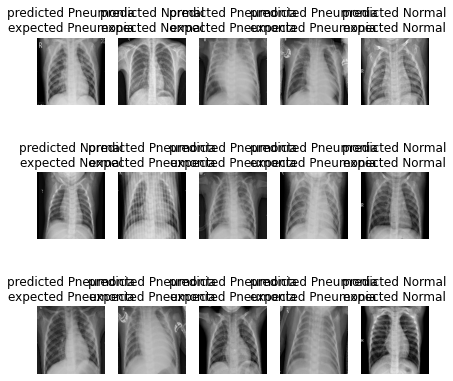

2/2 [==============================] - 1s 404ms/step - loss: 0.2710 - sparse_categorical_accuracy: 0.9375


In [109]:
data.showNN()

In [110]:
data.save_model()

the model has been saved in Model/model.h5
